In [44]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import os
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from IPython.display import Image
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
import zipfile
from google.colab import drive


In [46]:
zipped_train = '/content/drive/MyDrive/anime.zip'
z=zipfile.ZipFile(zipped_train,'r')
z.extractall(path='/content')

dir = '/content/anime'

In [7]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

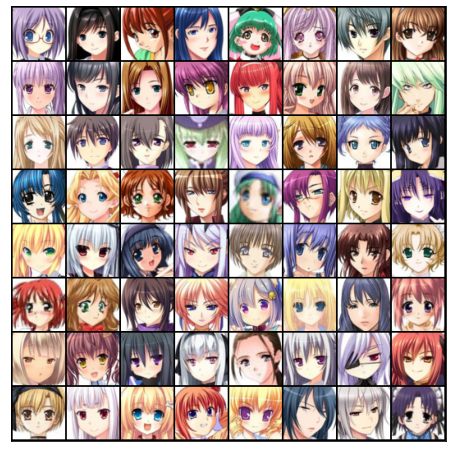

In [12]:
show_batch(train_dl)

In [13]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = torch.device('cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)

In [16]:
import torch.nn as nn

In [17]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),


    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [18]:
discriminator = to_device(discriminator, device)

In [19]:
latent_size = 128

In [20]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


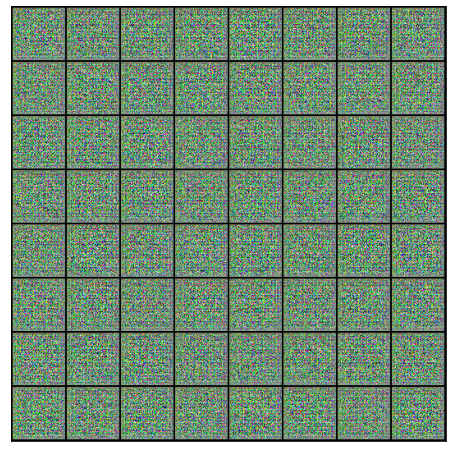

In [21]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [22]:
generator = to_device(generator, device)

In [23]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [24]:
def train_generator(opt_g):

    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    

    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    

    loss.backward()
    opt_g.step()
    
    return loss.item()

In [26]:
sample_dir = '/content/generated'
os.makedirs(sample_dir, exist_ok=True)

In [27]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [28]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


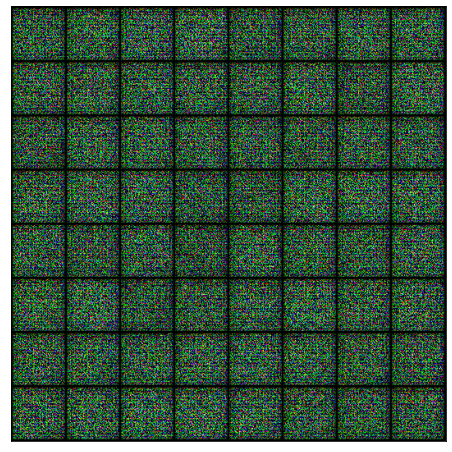

In [29]:
save_samples(0, fixed_latent)

In [31]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [32]:
lr = 0.0002
epochs = 25

In [35]:
history = fit(epochs, lr)


Epoch [1/25], loss_g: 5.0268, loss_d: 0.3406, real_score: 0.7801, fake_score: 0.0155
Saving generated-images-0001.png



Epoch [2/25], loss_g: 5.9296, loss_d: 0.1750, real_score: 0.9264, fake_score: 0.0729
Saving generated-images-0002.png



Epoch [3/25], loss_g: 6.1673, loss_d: 0.1110, real_score: 0.9542, fake_score: 0.0519
Saving generated-images-0003.png



Epoch [4/25], loss_g: 8.7874, loss_d: 0.0881, real_score: 0.9285, fake_score: 0.0004
Saving generated-images-0004.png



Epoch [5/25], loss_g: 9.5490, loss_d: 0.3892, real_score: 0.9358, fake_score: 0.2225
Saving generated-images-0005.png



Epoch [6/25], loss_g: 7.8628, loss_d: 0.1194, real_score: 0.9082, fake_score: 0.0013
Saving generated-images-0006.png



Epoch [7/25], loss_g: 10.7796, loss_d: 0.2103, real_score: 0.8494, fake_score: 0.0005
Saving generated-images-0007.png



Epoch [8/25], loss_g: 6.8534, loss_d: 0.0636, real_score: 0.9958, fake_score: 0.0529
Saving generated-images-0008.png



Epoch [9/25], loss_g: 5.4405, loss_d: 0.0944, real_score: 0.9441, fake_score: 0.0329
Saving generated-images-0009.png



Epoch [10/25], loss_g: 6.5267, loss_d: 0.1063, real_score: 0.9638, fake_score: 0.0559
Saving generated-images-0010.png



Epoch [11/25], loss_g: 10.1484, loss_d: 0.2715, real_score: 0.9668, fake_score: 0.1933
Saving generated-images-0011.png



Epoch [12/25], loss_g: 23.3411, loss_d: 0.9311, real_score: 0.9990, fake_score: 0.5313
Saving generated-images-0012.png



Epoch [13/25], loss_g: 3.7953, loss_d: 0.1716, real_score: 0.8858, fake_score: 0.0136
Saving generated-images-0013.png



Epoch [14/25], loss_g: 5.0446, loss_d: 0.0788, real_score: 0.9544, fake_score: 0.0237
Saving generated-images-0014.png



Epoch [15/25], loss_g: 8.4803, loss_d: 0.1577, real_score: 0.9895, fake_score: 0.1268
Saving generated-images-0015.png



Epoch [16/25], loss_g: 13.4373, loss_d: 0.0130, real_score: 0.9896, fake_score: 0.0005
Saving generated-images-0016.png



Epoch [17/25], loss_g: 11.3708, loss_d: 0.2517, real_score: 0.9943, fake_score: 0.1839
Saving generated-images-0017.png



Epoch [18/25], loss_g: 6.6811, loss_d: 0.1380, real_score: 0.9772, fake_score: 0.0922
Saving generated-images-0018.png



Epoch [19/25], loss_g: 5.6920, loss_d: 0.0610, real_score: 0.9938, fake_score: 0.0441
Saving generated-images-0019.png



Epoch [20/25], loss_g: 5.1775, loss_d: 0.0845, real_score: 0.9687, fake_score: 0.0447
Saving generated-images-0020.png



Epoch [21/25], loss_g: 5.0370, loss_d: 0.1294, real_score: 0.9076, fake_score: 0.0153
Saving generated-images-0021.png



Epoch [22/25], loss_g: 7.0904, loss_d: 0.0374, real_score: 0.9858, fake_score: 0.0217
Saving generated-images-0022.png



Epoch [23/25], loss_g: 10.0111, loss_d: 0.0048, real_score: 0.9982, fake_score: 0.0029
Saving generated-images-0023.png



Epoch [24/25], loss_g: 6.8166, loss_d: 0.1004, real_score: 0.9774, fake_score: 0.0690
Saving generated-images-0024.png



Epoch [25/25], loss_g: 4.0368, loss_d: 0.0678, real_score: 0.9552, fake_score: 0.0156
Saving generated-images-0025.png


In [36]:
losses_g, losses_d, real_scores, fake_scores = history

In [37]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

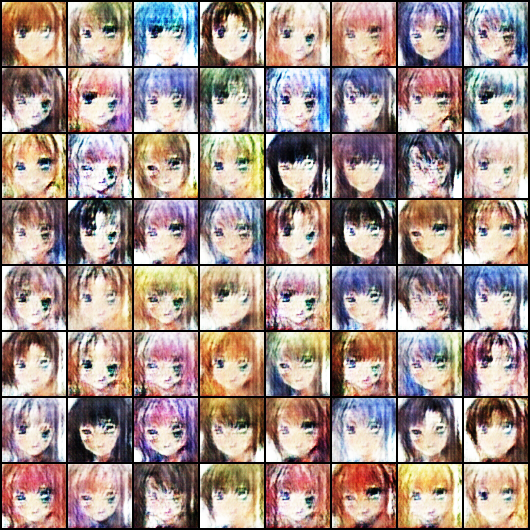

In [39]:
Image('./generated/generated-images-0001.png')

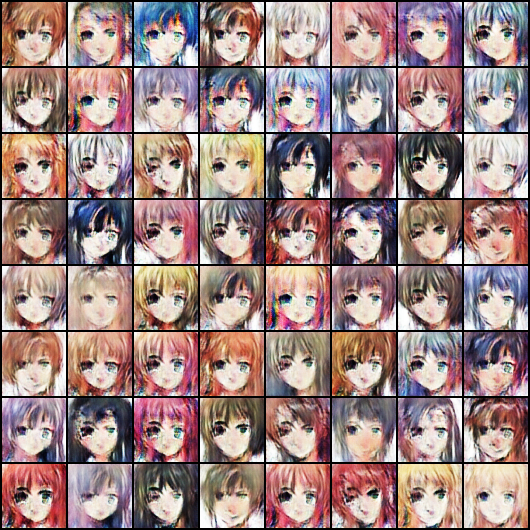

In [40]:
Image('./generated/generated-images-0005.png')

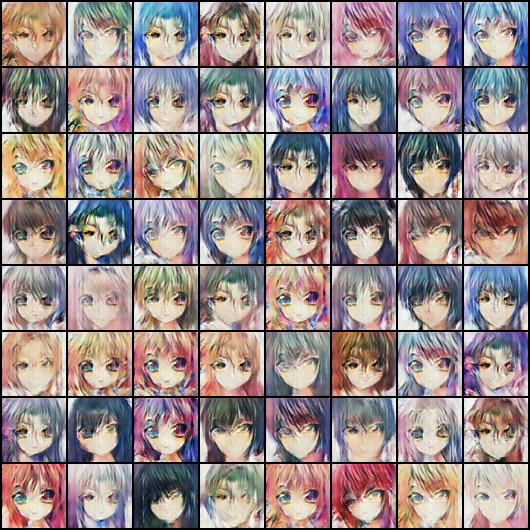

In [41]:
Image('./generated/generated-images-0010.png')

In [42]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

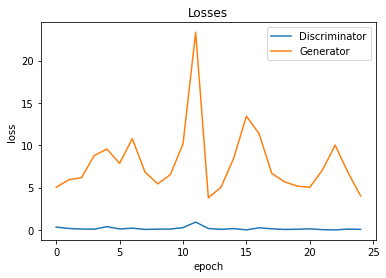

In [43]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')